In [4]:
import torch
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch.utils.data as Data

In [5]:
#Read the file
source_folders=glob("E:/Dataset/course/BS6207/ASS4/*")
source_folders

['E:/Dataset/course/BS6207/ASS4\\artifacts',
 'E:/Dataset/course/BS6207/ASS4\\cancer_regions',
 'E:/Dataset/course/BS6207/ASS4\\normal_regions',
 'E:/Dataset/course/BS6207/ASS4\\other']

In [36]:
print(len(artifactes_files))
print(len(cancer_regions_files))
print(len(normal_regions_files))
print(len(other_files))

2380
2878
1187
484


In [40]:
#Read file related to four labels respectively

normal_regions_files=glob(source_folders[2]+"/*")
cancer_regions_files=glob(source_folders[1]+"/*")
other_files=glob(source_folders[3]+"/*")
artifactes_files=glob(source_folders[0]+"/*")


#split the file into train and test

files_set=[artifactes_files,cancer_regions_files,normal_regions_files,other_files]
x_train=artifactes_files[100:484]+cancer_regions_files[100:484]+normal_regions_files[100:484]+other_files[100:484]
x_test=artifactes_files[0:100]+cancer_regions_files[0:100]+normal_regions_files[0:100]+other_files[0:100]

#label the training set

y_train=np.full((1,len(artifactes_files[100:484])),0)
y_train=np.append(y_train,np.full((1,len(cancer_regions_files[100:484])),1))
y_train=np.append(y_train,np.full((1,len(normal_regions_files[100:484])),2))
y_train=np.append(y_train,np.full((1,len(other_files[100:484])),3))


#label the test set

y_test=np.append(np.full((1,100),0),np.full((1,100),1))
y_test=np.append(y_test,np.full((1,100),2))
y_test=np.append(y_test,np.full((1,100),3))

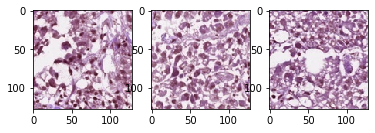

In [51]:
plt.subplot(1,3,1)
img=io.imread(files_set[1][0])
plt.imshow(img)

plt.subplot(1,3,2)
img2=io.imread(files_set[1][1])
plt.imshow(img2)

plt.subplot(1,3,3)
img3=io.imread(files_set[1][2])
plt.imshow(img3)

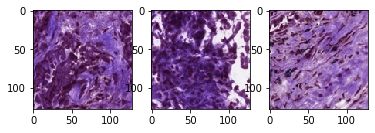

In [52]:
plt.subplot(1,3,1)
img=io.imread(files_set[0][0])
plt.imshow(img)

plt.subplot(1,3,2)
img2=io.imread(files_set[0][1])
plt.imshow(img2)

plt.subplot(1,3,3)
img3=io.imread(files_set[0][2])
plt.imshow(img3)

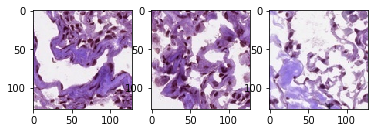

In [53]:
plt.subplot(1,3,1)
img=io.imread(files_set[2][0])
plt.imshow(img)

plt.subplot(1,3,2)
img2=io.imread(files_set[2][1])
plt.imshow(img2)

plt.subplot(1,3,3)
img3=io.imread(files_set[2][2])
plt.imshow(img3)

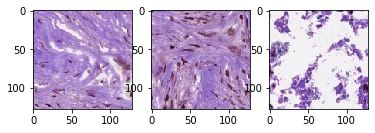

In [59]:
plt.subplot(1,3,1)
img=io.imread(files_set[3][0])
plt.imshow(img)

plt.subplot(1,3,2)
img2=io.imread(files_set[3][1])
plt.imshow(img2)

plt.subplot(1,3,3)
img3=io.imread(files_set[3][2])
plt.imshow(img3)

In [41]:
print("Total size for test data is "+str((len(x_test))))
print("Total size for training data is "+str((len(x_train))))

Total size for test data is 400
Total size for training data is 1536


In [28]:
#read the data from the file

def x_to_data(x_list):
    xlist=[]
    i=0
    for x in x_list:
        
        print(i)
        img=io.imread(x)
        img=np.swapaxes(img,0,2)
        img=np.swapaxes(img,1,2)
        xlist.append(img)
        i+=1
    return xlist

def classification_report_show(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=['Artifactes','Cancer Regions','Normal Regions','Others'] ))
    sns.heatmap(cm, annot=True,fmt='g',cmap ='Reds',xticklabels=['Artifactes','Cancer Regions','Normal Regions','Others'],yticklabels=['Artifactes','Cancer Regions','Normal Regions','Others'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
def model_prediction(Model,X):
    test_pred = Model(X)
    res =test_pred.data
    y_pred=torch.max(res,1)[1]
    return y_pred

In [15]:
x_test_tensor=torch.tensor(x_to_data(x_test)).float()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
y_train_tensor=torch.tensor(y_train)

In [42]:
x_train=x_to_data(x_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
x_train_tensor_2=torch.tensor(x_train).float()
x_train_tensor_2.shape

torch.Size([1536, 3, 128, 128])

In [22]:
y_train_tensor_2=torch.tensor(y_train)

In [40]:
#Build the VGG model

class Model_VGG(torch.nn.Module):
    def __init__(self):
        super(Model_VGG, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 512, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(32768, 4096),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1000),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(1000,4),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [55]:

cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 512, kernel_size=2, stride=1, padding=1),
            #BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

In [58]:
test=cnn_layers(x_train_tensor_2[0:1])
test.shape

torch.Size([1, 512, 8, 8])

In [42]:
model=Model_VGG()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

for i in range(500):
    optimizer.zero_grad()
    
    prediction = model(x_train_tensor)
    loss = loss_func(prediction, y_train_tensor.long())
    
    # Back propagation for loss
    loss.backward()
    # Optimize parameter based on the least loss
    optimizer.step()
    print("Time={} Loss={}".format(i, loss.data.numpy()))

Time=0 Loss=1.6510579586029053
Time=1 Loss=1519.092041015625
Time=2 Loss=38.11382293701172
Time=3 Loss=5.7652997970581055
Time=4 Loss=7.709152698516846
Time=5 Loss=3.9204914569854736
Time=6 Loss=2.163144111633301
Time=7 Loss=1.367354154586792
Time=8 Loss=1.542682409286499
Time=9 Loss=1.3706306219100952
Time=10 Loss=1.3012572526931763
Time=11 Loss=1.268066167831421
Time=12 Loss=1.185172438621521
Time=13 Loss=1.4048126935958862
Time=14 Loss=1.3536628484725952
Time=15 Loss=1.48165762424469
Time=16 Loss=1.4830979108810425
Time=17 Loss=1.4343485832214355
Time=18 Loss=1.3682546615600586
Time=19 Loss=1.320314884185791
Time=20 Loss=1.3682284355163574
Time=21 Loss=1.2886161804199219
Time=22 Loss=1.2787840366363525
Time=23 Loss=1.2299104928970337
Time=24 Loss=1.2152786254882812
Time=25 Loss=3.024287700653076
Time=26 Loss=1.3459570407867432
Time=27 Loss=1.3410727977752686
Time=28 Loss=1.2347314357757568
Time=29 Loss=1.3300330638885498
Time=30 Loss=1.2104703187942505
Time=31 Loss=1.100330591201782

                precision    recall  f1-score   support

    Artifactes       0.86      0.95      0.90       100
Cancer Regions       0.83      0.81      0.82       100
Normal Regions       0.82      0.74      0.78       100
        Others       0.90      0.91      0.91       100

      accuracy                           0.85       400
     macro avg       0.85      0.85      0.85       400
  weighted avg       0.85      0.85      0.85       400



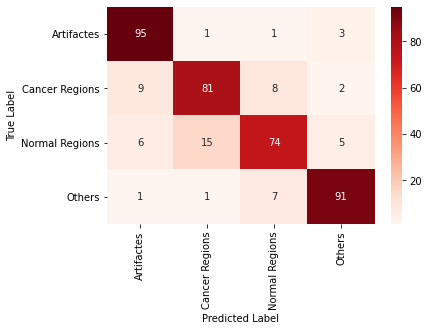

In [49]:
y_pred=model_prediction(model,x_test_tensor)
classification_report_show(y_test,y_pred)

In [44]:
def PrepareTrainData(x,y):
    traindata=[]
    for i in range(0,len(x)):
        traindata.append([x[i],y[i]])
    return traindata

In [27]:
train_data_2=PrepareTrainData(x_train_tensor_2,y_train_tensor_2)

In [29]:
loader_2 = Data.DataLoader(
    dataset=train_data_2,      # torch TensorDataset format
    batch_size=40,      
    shuffle=True,               # shuffle the data
    num_workers=2,              # thread to use
)

In [114]:
model=Model_VGG()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

In [115]:
for epoch in range(20):  # loop over the dataset multiple times
    print("Epoch {}".format(epoch+1))
    for i, data in enumerate(loader_2, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(inputs)
        loss = loss_func(prediction,labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1) % 10 == 0:
            print("Epoch={} Time={} Loss={}".format(epoch+1,i+1, loss.data.numpy()))  

Epoch 1
Epoch=1 Time=10 Loss=2.299450397491455
Epoch=1 Time=20 Loss=1.4899911880493164
Epoch 2
Epoch=2 Time=10 Loss=1.0151602029800415
Epoch=2 Time=20 Loss=1.017962098121643
Epoch 3
Epoch=3 Time=10 Loss=1.073127031326294
Epoch=3 Time=20 Loss=0.8278266191482544
Epoch 4
Epoch=4 Time=10 Loss=1.0741231441497803
Epoch=4 Time=20 Loss=1.0721564292907715
Epoch 5
Epoch=5 Time=10 Loss=0.9538301229476929
Epoch=5 Time=20 Loss=0.8536734580993652
Epoch 6
Epoch=6 Time=10 Loss=0.5253232717514038
Epoch=6 Time=20 Loss=0.7270690202713013
Epoch 7
Epoch=7 Time=10 Loss=0.5969606637954712
Epoch=7 Time=20 Loss=0.5122968554496765
Epoch 8
Epoch=8 Time=10 Loss=0.4009634554386139
Epoch=8 Time=20 Loss=0.5629273653030396
Epoch 9
Epoch=9 Time=10 Loss=0.4127507209777832
Epoch=9 Time=20 Loss=0.5151644945144653
Epoch 10
Epoch=10 Time=10 Loss=0.5071219205856323
Epoch=10 Time=20 Loss=0.2087302953004837
Epoch 11
Epoch=11 Time=10 Loss=0.3792930543422699
Epoch=11 Time=20 Loss=0.5447567105293274
Epoch 12
Epoch=12 Time=10 Los

                precision    recall  f1-score   support

    Artifactes       0.83      0.96      0.89       100
Cancer Regions       0.88      0.68      0.77       100
Normal Regions       0.74      0.80      0.77       100
        Others       0.83      0.83      0.83       100

      accuracy                           0.82       400
     macro avg       0.82      0.82      0.82       400
  weighted avg       0.82      0.82      0.82       400



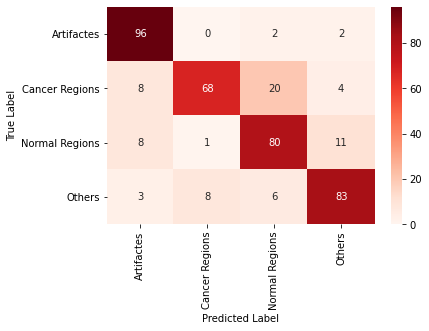

In [116]:
y_pred=model_prediction(model,x_test_tensor)
classification_report_show(y_test,y_pred)

In [60]:
#New VGG model with batch normalization,the result will be run on my teamamates computer and show on the report

class Model_VGG_2(torch.nn.Module):
    def __init__(self):
        super(Model_VGG_v2, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 512, kernel_size=2, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(32768, 4096),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1000),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(1000,4),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x